# Problem 18

Use Peng Robinson EOS to perform (a) flash at 500 psia and 280 deg F, followed by (b) Michelson phase stability test and two phase flash at 1,500 psia and 280 deg F

For this exercise I'm going to introduce the component Python class concept which makes tracking component parameters easier, which we'll use again in the worked example in Appendix C. The way Python code is structured, functions need to be scripted prior to being called, so you will find a lot of function definitions before we actually start defining the problem scenario.

*Note: Eq 4.23 quoted both in section 4, as well as in the Fugacity calculation in this example are all incorrect (and inconsistent). The denominator inside the last natural log should actually be [Z + (1-sqrt(2))*B]

In [1]:
import math
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol

In [2]:
#Create a component class object to track all values togeather
#note - the bip variable expects a list of length = 4, for the bip's associated with the components and N2, CO2, H2S and CH4 respectively
class comp:
    def __init__ (self, name, M, gamma, rhosc, Pc, Tc, vc, w, tb, L, H, s, bip):
        self.name = name
        self.M = M
        self.gamma = gamma
        self.rhosc = rhosc
        self.Pc = Pc
        self.Tc = Tc
        self.vc = vc
        self.w = w
        self.tb = tb
        self.L = L
        self.H = H
        self.s = s
        self.bip = bip
        
    def zc(self):
        global R
        return (self.Pc)*(self.vc)/(R*(self.Tc))

comp_lib = [0]*18
#From Tables A-1A, 4.3 & A-3 in Oilfield Units 
#                  Name,  MW.   SG,   rhosc,  Pc,   Tc,    vc,     w,     tb,    L, H,  s=v/d,    bic
comp_lib[0] = comp('N2', 28.02, 28.02/28.97, 29.31, 493.0, 227.3, 1.443, 0.0450, 139.3, 0, 0, -0.1927, [0,0,0,0])
comp_lib[1] = comp('CO2', 44.01, 44.01/28.97, 31.18, 1070.6, 547.6, 1.505, 0.2310, 350.4, 0, 0, -0.0817, [0,0,0,0])
comp_lib[2] = comp('H2S', 34.08, 34.08/28.97, 31.18, 1306.0, 672.4, 1.564, 0.10, 383.1, 0,672.0, -0.1288, [0.13,0.135,0,0])
comp_lib[3] = comp('C1', 16.04, 0.33, 20.58, 667.8, 343.0, 1.59, 0.0115, 201, 0, 1012.0, -0.1595, [0.025,0.105,0.07,0])
comp_lib[4] = comp('C2', 30.07, 0.45, 28.06, 707.8, 549.8, 2.37, 0.0908, 332.2, 0, 1783.0, -0.1134, [0.01,0.13,0.085,0])
comp_lib[5] = comp('C3', 44.09, 0.5077, 31.66, 616.3, 665.7, 3.25, 0.1454, 416.0, 27.4, 2557.0, -0.0863, [0.09,0.125,0.08,0])
comp_lib[6] = comp('iC4', 58.12, 0.5613, 35.01, 529.1, 734.7, 4.208, 0.1756, 470.6, 32.7, 3354.0, -0.0844, [0.095,0.12,0.075,0])
comp_lib[7] = comp('nC4', 58.12, 0.5844, 36.45, 550.7, 765.3, 4.08, 0.1928, 490.8, 31.4, 3369.0, -0.0675, [0.095,0.115,0.075,0])
comp_lib[8] = comp('iC5', 72.15, 0.6274, 39.13, 490.4, 828.8, 4.899, 0.2273, 541.8, 36.3, 4001.0, -0.0608, [0.1,0.115,0.07,0])
comp_lib[9] = comp('nC5', 72.15, 0.6301, 39.30, 488.6, 845.4, 4.870, 0.2510, 556.6, 36.2, 4009.0, -0.0390, [0.11,0.115,0.07,0])
comp_lib[10] = comp('C6', 86.17, 0.6604, 41.19, 436.9, 913.4, 5.929, 0.2957, 615.4, 41.2, 4756.0, -0.0080, [0.11,0.115,0.055,0])
comp_lib[11] = comp('C7', 100.2, 0.6828, 42.58, 396.8, 972.5, 6.924, 0.3506, 668.8, 46.3, 5503.0, 0.0033, [0.11,0.115,0.05,0])
comp_lib[12] = comp('C8', 114.2, 0.7086, 44.19, 360.6, 1023.9, 7.882, 0.3978, 717.9, 50.9, 6250.0, 0.0314, [0.11,0.115,0.048,0])
comp_lib[13] = comp('C9', 128.3, 0.7271, 45.35, 332.0, 1070.3, 8.773, 0.4437, 763.1, 55.7, 6996.0, 0.0408, [0.11,0.115,0.046,0])
comp_lib[14] = comp('C10', 142.29, 0.7324, 45.68, 304.0, 1111.8, 9.661, 0.4902, 805.2, 61.4, 7743.0, 0.0655, [0.11,0.115,0.045,0])
comp_lib[15] = comp('Air', 28.97, 1, 29.31, 547.0, 239.0, 1.364, 0.04, 141.9, 0, 0, 0, [0.0,0.0,0.0,0.0])
comp_lib[16] = comp('H2O', 18.02, 1.00, 62.37, 3206.0, 1165.0, 0.916, 0.344, 671.6, 0, 0, 0,  [0.0,0.0,0.0,0.0])
comp_lib[17] = comp('O2', 32.0, 32.0/28.97, 31.18, 732.0, 278.0, 1.174, 0.025, 162.2, 0, 0, 0,  [0.0,0.0,0.0,0.0])


In [3]:
# Build complete initial binary interaction parameter list
def build_bips(comps):
    bip_list=[]
    for item_row in comps:
        bip_row = []
        for item_col in comps:
            if comps.index(item_col) > comps.index(item_row): # Only generate BIP matrix entries for lower left
                continue
            if item_col.name == "N2":
                bip_row.append(item_row.bip[0])
                continue
            if item_col.name == "CO2":
                bip_row.append(item_row.bip[1])
                continue
            if item_col.name == "H2S":
                bip_row.append(item_row.bip[2])
                continue
            if item_col.name == "C1":
                bip_row.append(item_row.bip[3])
                continue
            bip_row.append(0)
        bip_list.append(bip_row)
    return bip_list

In [4]:
# Calculate ai required for P-R EOS formulation
def ai_calc(w, Tc, Pc, t, p):
    global R
    if w <= 0.49:
        m = 0.37464+1.54226*w-0.26992*w**2 #Eq 4.21
    else:
        m = 0.3796+1.485*w-0.1644*w**2+0.01667*w**3 # Eq 4.22
    Tr=t/Tc
    alpha=(1+m*(1-Tr**0.5))**2
    a = 0.45724*R**2*Tc**2*alpha/Pc
    return a

# Calculate bi required for P-R EOS formulation
def bi_calc(Tc, Pc):
    global R
    b = 0.07780*R*Tc/Pc
    return b

In [5]:
# Contrasts the Ln(Fugacities) of pure liquid and vapor phases to ensure correct single phase is chosen
# when two phase solution not possible from Rachford Rice material balance evaluation
def compare_phases(z, Ki, ai, bi, bip_list, p, t):
        ncomps = len(z)
        # Calculate liquid fugacity
        xi = [ z[i] for i in range(ncomps)]
        yi = [ z[i] * Ki[i] for i in range(ncomps)]
        aij, Al, Av, Bl, Bv = calc_aij(xi, yi, ai, bi, bip_list)
        Zl = zroots(Al, Bl, p, t)
        ln_phi_l = min(Zl[i]-1-math.log(Zl[i]-Bl)-Al/(2.8284271247461903 * Bl)*math.log((Zl[i] + 2.414213562373095 * Bl) / (Zl[i] - 0.41421356237309515 * Bl)) for i in range(len(Zl))) 
        
        # Calculate vapor fugacity
        yi = [ z[i] for i in range(ncomps)]
        xi = [ z[i] / Ki[i] for i in range(ncomps)]
        aij, Al, Av, Bl, Bv = calc_aij(xi, yi, ai, bi, bip_list)
        Zv = zroots(Av, Bv, p, t)
        ln_phi_v = min(Zv[i]-1-math.log(Zv[i]-Bv)-Av/(2.8284271247461903 * Bv)*math.log((Zv[i] + 2.414213562373095 * Bv) / (Zv[i] - 0.41421356237309515 * Bv)) for i in range(len(Zv)))  
        
        if ln_phi_l < ln_phi_v: # Choose phase with lowest fugacity
            Fv = 0
        else:
            Fv = 1
        return Fv

In [6]:
from scipy.optimize import brentq
# Calculate vapor fraction using Rachford Rice
def calc_fv(Ki, z, ai, bi, bip_list, p, t):
    ncomps = len(z)
    Fv_min = 0
    Fv_max = 1
    if max(Ki) != 1:
        Fv_min = max(min(1/(1-max(Ki)),1),0)
        #Fv_min = 1/(1-max(Ki))
    if min(Ki) != 1:
        Fv_max = max(min(1/(1-min(Ki)),1),0)
        #Fv_max = 1/(1-min(Ki))
    
    RRmin = sum(z[i]*(Ki[i]-1)/(1+Fv_min*(Ki[i]-1)) for i in range(ncomps))
    RRmax = sum(z[i]*(Ki[i]-1)/(1+Fv_max*(Ki[i]-1)) for i in range(ncomps))
    
    if RRmin * RRmax >= 0: # Both errors have same sign - Choose the single phase with lowest Fugacity
        Fv = compare_phases(z, Ki, ai, bi, bip_list, p, t)
    
    else: # Must be a solution - use bounded solver
        params = (z, Ki)
        Fv = brentq(RR, Fv_min, Fv_max, args=params) # Use in-built Python solver brentq
    
    return Fv

In [7]:
# Calculate fugacity of a component, Eq 4.23
def fi(a, b, Z, bi, aij, p, yi, i, ci):
    global R
    A = a * p / (R*t)**2
    B = b * p / (R*t)
    
    ncomps = len(yi)
    sum_aij_y = sum(yi[j]*aij[i][j] for j in range(ncomps))

    c1 = (bi[i]/b) * (Z - 1)  - math.log(Z - B)
    c2 = (A / (2.8284271247461903 * B)) * ((bi[i] / b) - ((2/a) * sum_aij_y ))
    c3 = math.log((Z + 2.414213562373095 * B) / (Z - 0.41421356237309515 * B))
    phi = (c1 + c2 * c3)

    return math.exp(phi)*yi[i]*p

In [8]:
# Return cubic Z roots of PR EOS using Numpy Python root finder numpy.roots
def zroots(a, b, p, t):    
    global R
    A = a * p / (R*t) ** 2 # Eq 4.9
    B = b * p / (R*t)
    
    p1 = B - 1
    p2 = A - 3 * B ** 2 - 2 * B
    p3 = -(A * B - B ** 2 - B ** 3)   # Eq 4.19
    
    roots = np.roots([1,p1,p2,p3]) 
    Zroot = []
    for item in roots:
        if np.iscomplex(item): # Remove complex roots
            item = None
            continue
        else:
            item = item.real   # Catch solutions with +0i and convert to real
            Zroot.append(item)
    
    # If 3 real roots returned, eliminate the middle one
    if len(Zroot) == 3:
            Zroot.sort()
            Zroot.pop(1)
            
    return(Zroot)

In [9]:
# Calculate fugacities and total Gibbs free energy for each of the roots,
# then return fugacities for the outcome with lowest Gibbs free energy
def fugacities(Z, a, b, bi, aij, p, xi, ci):
    global R
    nroots = len(Z)
    ncomps = len(xi)
    min_gibbs = 1e99
    minidx = 0
    for root in range(nroots):
        fi_p = [fi(a, b, Z[root], bi, aij, p, xi, i, ci) for i in range(ncomps)]
        gibbs = sum(xi[i] * math.log(fi_p[i]) for i in range(ncomps))
        if gibbs < min_gibbs:
            min_gibbs = gibbs
            min_fugacities = fi_p
    return min_fugacities

In [10]:
def calc_aij(xi, ai, bip_list): # Calculates the Aij terms required in Eq 4.23
    aij = []
    ncomps = len(xi)
    for i in range(ncomps):
        row = []
        for j in range(ncomps):
            ii = i
            jj = j
            if ii < jj:
                ii = j
                jj = i
            aij_temp = (ai[i]*ai[j])**0.5*(1-bip_list[ii][jj])
            row.append(aij_temp)
        aij.append(row)
    return aij

def calc_A_B(xi, aij, bi, bip_list): # Calculates the A & B terms required in Eq 4.23
    A = B = 0
    ncomps = len(xi)
    for i in range(ncomps):
        row = []
        B += xi[i]*bi[i]
        for j in range(ncomps):
            ii = i
            jj = j
            if ii < jj:
                ii = j
                jj = i
            A += xi[i]*xi[j]*aij[i][j]
    return [A, B]

In [11]:
# Peng Robinson Flash calculation
def flash(p, t, comps, z, Ki, tol, maxiter, verbose = 0): # verbose = 0 will return no dialog. 1: will return all iterations, anything else will return final iteration results
    ncomps=len(comps)
    fi_l, fi_v = ([0]*ncomps for i in range(2))
    solve_err = 1000
    
    table = []
    niter = 0
    nexp = 1
    ngdem = 0
    
    #Calculate ai, bi, ci values
    ai=[ai_calc(comps[i].w, comps[i].Tc, comps[i].Pc, t, p) for i in range(ncomps)]
    bi=[bi_calc(comps[i].Tc, comps[i].Pc) for i in range(ncomps)]
    ci =[bi[i]*comps[i].s for i in range(ncomps)]
    
    # Start flash iterative solver
    while solve_err > tol:
                    
        # Solve Rachford Rice for Vapor fraction
        Fv = calc_fv(Ki, z, ai, bi, bip_list, p, t)
            
        # (Re)calculate liquid and vapor molar fractions, 
        xi = [ z[i]/(Fv*(Ki[i]-1)+1) for i in range(ncomps)]
        yi = [ xi[i]*Ki[i] for i in range(ncomps)]
        
        # Recalculate Aij, Al/v and Bl/v
        aij = calc_aij(xi, ai, bip_list)
        
        Al, Bl = calc_A_B(xi, aij, bi, bip_list)
        Av, Bv = calc_A_B(yi, aij, bi, bip_list)
        
        # Calculate liquid and vapor phase roots
        Zl = zroots(Al, Bl, p, t)
        Zv = zroots(Av, Bv, p, t)

        # Calculate fugacities of the components for the lowest Gibbs free energy roots
        fi_l = fugacities(Zl, Al, Bl, bi, aij, p, xi, ci)
        fi_v = fugacities(Zv, Av, Bv, bi, aij, p, yi, ci)
            
              
        New_Rr = [fi_l[i]/fi_v[i] for i in range(ncomps)]
        lamb = 1
        ngdem +=1
        
        if ngdem == 4: # GDEM acceleration every fourth substitution
            b11 = sum((math.log(Rr[i]))**2 for i in range(ncomps)) # Eq 4.72
            b01 = sum(math.log(Rr[i])*math.log(New_Rr[i]) for i in range(ncomps))
            lamb = abs(b11/(b11-b01))
            ngdem = 0
             
        # Calculate new error, and estimates for Ki's
        Rr = New_Rr.copy()
        solve_err = sum((Rr[i]-1)**2 for i in range(ncomps))
        Kold = Ki.copy()
        fi_l_old = fi_l.copy()
        fi_v_old = fi_v.copy()
        
        Ki = [Ki[i]*Rr[i]**lamb for i in range(ncomps)] # New estimate of Ki - Goal is to have equal fugacities in liquid and vapor phases
            
        # Track results for troubleshooting / checking
        if verbose !=0:
            if solve_err < tol or verbose == 1 or niter == maxiter:
                table.append(['Iteration:', str(niter+1)+', Lambda:'+str(round(lamb,3)), ' ', 'Fv:', Fv, ' ', ' '])
                for i in range(ncomps):
                    table.append([comps[i].name, str(round(yi[i],6)), str(round(xi[i],6)), str(round(Ki[i],6)), str(round(fi_v[i],6)), str(round(fi_l[i],6)), str(round(fi_l[i]/fi_v[i],6))])    
                table.append(['Error:', str(solve_err) , ' ', 'Zl ',(Zl), ' Zv', (Zv)])
                table.append([' ', ' ' , ' ', ' ', ' ', ' ', ' '])
        
        niter +=1
        if niter > maxiter:
            break
            
    return [Fv, xi, yi, Ki, fi_l, fi_v, Zv[0], table]

In [12]:
# Build components list for Problem 18
comps = []
comps.append(comp_lib[3])
comps.append(comp_lib[7])
comps.append(comp_lib[14])

# And molar fractions
z = [0.5, 0.42, 0.08]

# Zero out binary interaction coefficients that are not used in this exercise
bip_list = [[0,0,0],[0,0,0],[0,0,0]]
bip_list = build_bips(comps)

In [13]:
ncomps = len(comps)
    
print('Table B-28 Ternary System (Problem 18)')
header=['Component', 'z', 'MW', 'Tc', 'Pc', 'w', 's']
table = []
for i in range(ncomps):
    table.append([comps[i].name, z[i], comps[i].M, comps[i].Tc, comps[i].Pc, comps[i].w, comps[i].s])
print(tabulate(table,headers=header))

Table B-28 Ternary System (Problem 18)
Component       z      MW      Tc     Pc       w        s
-----------  ----  ------  ------  -----  ------  -------
C1           0.5    16.04   343    667.8  0.0115  -0.1595
nC4          0.42   58.12   765.3  550.7  0.1928  -0.0675
C10          0.08  142.29  1111.8  304    0.4902   0.0655


In [14]:
# Estimate initial equilibrium K values using Wilson's equation (Eq 4.42)
def k_wilson(comps, t, p):
    return [math.exp(5.37*(1+comps[i].w)*(1-1/(t/comps[i].Tc)))/(p/comps[i].Pc) for i in range(len(comps))]

In [15]:
#Initialize the components with first approximation Ki's
p = 500 #psia
t = 280+460 # deg R
Ki = k_wilson(comps, t, p)

In [16]:
def RR(Fv, *params): # Rachford Rice material balance error
    z, Ki = params
    return sum(z[i]*(Ki[i]-1)/(1+Fv*(Ki[i]-1)) for i in range(len(z))) # Eq 4.36

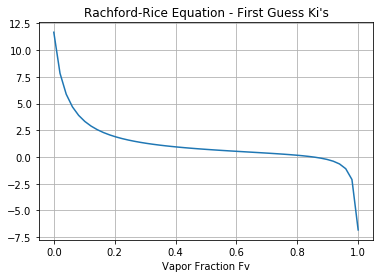

In [17]:
# And plot the associated initial guess Rachford-Rice plot
Fv_plot = np.linspace(0,1)
params = (z, Ki)
plt.plot(Fv_plot,[RR(Fv_plot, *params) for Fv_plot in Fv_plot])
plt.xlabel('Vapor Fraction Fv')
plt.title("Rachford-Rice Equation - First Guess Ki's")
plt.grid();

In [18]:
# Now, perform first flash
Fv, xi, yi, Ki, fi_l, fi_v, Zv, result_table = flash(p,t,comps,z, Ki, 1e-11, 500, 1)

print('Table B-30 Fugacity Calculation Results (Problem 18)')
header=['Component', 'yi', 'xi', 'Ki', 'fvi', 'fli', 'fli/fvi']
print(tabulate(result_table,headers=header))

Table B-30 Fugacity Calculation Results (Problem 18)
Component    yi                      xi        Ki        fvi                    fli         fli/fvi
-----------  ----------------------  --------  --------  ---------------------  ----------  --------------------
Iteration:   1, Lambda:1                       Fv:       0.8526194158637006
C1           0.582339                0.023656  7.046379  297.902884             85.27127    0.286238
nC4          0.412091                0.465753  0.894812  149.672613             151.36887   1.011333
C10          0.00557                 0.510591  0.034255  1.076913               3.381757    3.140231
Error:       5.090174376496563                 Zl        [0.18131792258835538]  Zv          [0.8786570281407549]

Iteration:   2, Lambda:1                       Fv:       0.854378494448356
C1           0.571399                0.081091  6.688487  294.411978             279.458536  0.949209
nC4          0.412931                0.461473  0.892363  148.6323

In [19]:
def phase_test(p, t, comps, ai, bi, ci, z, fi_z, phase):
    # Initial estimate for k-values using an empirical equation
    Ki = k_wilson(comps, t, p)

    triv_lim = 1e-4
    conv_lim = 1e-10
    max_iter = conv_error = triv_err = 100

    j = 0
    while (conv_error > conv_lim) and (triv_err > triv_lim) and (j < max_iter):
        j += 1

        # create a second phase
        if phase == 'v':
            yi = [z[i]*Ki[i] for i in range(ncomps)] # Creating an incipient vapor phase
        else:
            yi = [z[i]/Ki[i] for i in range(ncomps)] # Creating an incipient liquid phase
            
        S = sum(yi)

        # normalize the mole fractions
        yi = [yi[i]/S for i in range(ncomps)]
    
        # Recalculate Aij yi mix
        aij = calc_aij(yi, ai, bip_list)

        # Calculate A & B
        A, B = calc_A_B(yi, aij, bi, bip_list) # Calculates the A & B terms required in Eq 4.23
        
        # Calculate roots
        Z = zroots(A, B, p, t)
    
        # Calculate fugacities of the components for the lowest Gibbs free energy roots
        fi = fugacities(Z, A, B, bi, aij, p, yi, ci)

        # correct K-values
        if phase == 'v':
            Ri = [fi_z[i]/fi[i]*(1/S) for i in range(ncomps)]
        else:
            Ri = [fi[i]/fi_z[i]*S for i in range(ncomps)]
            
        Ki = [Ki[i]*Ri[i] for i in range(ncomps)]

        #calculate the convergence and trivial solution error values
        conv_err = sum((Ri[i]-1)**2 for i in range(ncomps))
        triv_err = sum(math.log(Ki[i])**2 for i in range(ncomps))

    if (conv_err > conv_lim):
        flag = 1 # trivial solution

    elif (triv_err > triv_lim):
        flag = 2 # converged

    elif (j >= max_iter):
        flag = 3 # max iterations

    return [flag, S, yi, fi, Ki]

In [20]:
# Michelson stability test algorithm
def michelson(p, t, comps):
    bip_list = build_bips(comps)
    
    #Calculate ai, bi, ci values
    ai=[ai_calc(comps[i].w, comps[i].Tc, comps[i].Pc, t, p) for i in range(ncomps)]
    bi=[bi_calc(comps[i].Tc, comps[i].Pc) for i in range(ncomps)]
    ci =[bi[i]*comps[i].s for i in range(ncomps)]

    # Calculate Aij zi mix
    aij = calc_aij(z, ai, bip_list)

    # Calculate A & B for zi mixture
    A, B = calc_A_B(z, aij, bi, bip_list) # Calculates the A & B terms required in Eq 4.23

    # Calculate mixture roots
    Zmix = zroots(A, B, p, t)
    
    # Calculate fugacities of the components for the lowest Gibbs free energy roots
    fi_z = fugacities(Zmix, A, B, bi, aij, p, z, ci)

    # Solve for each of the incipient phases
    vap_stability, Sv, yi_v, fyi_v, Ki_v = phase_test(p, t, comps, ai, bi, ci, z, fi_z, 'v')
    liq_stability, Sl, yi_l, fyi_l, Ki_l = phase_test(p, t, comps, ai, bi, ci, z, fi_z, 'l')
    
    return [vap_stability, Sv, yi_v, fyi_v, Ki_v, liq_stability, Sl, yi_l, fyi_l, Ki_l, fi_z]
    

In [21]:
# Perform Michelson stability test and print results

t = 280 + 460 # deg R
p = 1500 # psia

vap_stability, Sv, yi_v, fyi_v, Ki_v, liq_stability, Sl, yi_l, fyi_l, Ki_l , fz = michelson(p, t, comps)
print('Table B-31 - Phase Stability Test Results (Problem 18, part B)')
header=['Component', 'yi', 'zi', 'Ki', 'fyi', 'fzi', 'S']
table = []
table.append([' ', ' ', 'Vapor-like', 'Stability Test', 'Ki=yi/zi', ' ', ' '])
for i in range(ncomps):
    table.append([comps[i].name, round(yi_v[i],5), z[i], round(Ki_v[i],4), round(fyi_v[i],1), round(fz[i],1), round(fz[i]/fyi_v[i],4)])

table.append([' ', ' ', 'Liquid-like', 'Stability Test', 'Ki=zi/yi', ' ', ' '])
for i in range(ncomps):
    table.append([comps[i].name, round(yi_l[i],5), z[i], round(Ki_l[i],4), round(fyi_l[i],1), round(fz[i],1), round(fz[i]/fyi_l[i],4)])
    
print(tabulate(table,headers=header))
print(' ')
print('Sv:', round(Sv,4))
print('Sl:', round(Sl,4))


Table B-31 - Phase Stability Test Results (Problem 18, part B)
Component    yi       zi           Ki              fyi       fzi     S
-----------  -------  -----------  --------------  --------  ------  ------
                      Vapor-like   Stability Test  Ki=yi/zi
C1           0.66824  0.5          1.352           1052.8    1065.0  1.0116
nC4          0.30993  0.42         0.7465          195.1     197.4   1.0116
C10          0.02183  0.08         0.276           2.7       2.8     1.0116
                      Liquid-like  Stability Test  Ki=zi/yi
C1           0.3182   0.5          1.5452          1047.3    1065.0  1.0169
nC4          0.47674  0.42         0.8663          194.1     197.4   1.0169
C10          0.20507  0.08         0.3836          2.7       2.8     1.0169
 
Sv: 1.0116
Sl: 1.0169


In [22]:
# Starting point set of Ki's post stability test
Ki =[yi_v[i]/yi_l[i] for i in range(ncomps)]

# And perform second flash
Fv, xi, yi, Ki_final, fi_l, fi_v, Zv, result_table = flash(p,t,comps,z, Ki, 1e-11, 500, -1) # Use a -1 verbose flag to return only final result

print('Table B-32 - Converged Flash Solution (Problem 18)')
header=['Component', 'K from stability test', 'yi', 'xi', 'Ki', 'fvi', 'fli']
table = []
for i in range(ncomps):
    table.append([comps[i].name, round(Ki[i],5), round(yi[i],6), round(xi[i],6), round(Ki_final[i],5), round(fi_v[i],2), round(fi_l[i],2)])
print(tabulate(table,headers=header))

Table B-32 - Converged Flash Solution (Problem 18)
Component      K from stability test        yi        xi       Ki      fvi      fli
-----------  -----------------------  --------  --------  -------  -------  -------
C1                           2.10009  0.629313  0.3299    1.90759  1019.12  1019.12
nC4                          0.65011  0.349116  0.513241  0.68022   210.52   210.52
C10                          0.10644  0.021571  0.156859  0.13752     2.28     2.28
